In [60]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [76]:
image_path = r"C:\Users\vamsi\Downloads\RSICD_images\RSICD_images"

In [77]:
# Read the Excel file
data = pd.read_excel(r"C:\Users\vamsi\Downloads\Modified_Book2.xlsx")

# Display the first few rows of the DataFrame
print(data.head())

           image                                            caption
0  airport_1.jpg  many planes are parked next to a long building...
1  airport_1.jpg  many planes are parked next to a long building...
2  airport_1.jpg  many planes are parked next to a long building...
3  airport_1.jpg  many planes are parked next to a long building...
4  airport_1.jpg  many planes are parked next to a long building...


In [78]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(r"C:\Users\vamsi\Downloads\RSICD_images\RSICD_images{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [79]:
#display_images(data.sample(15))

In [80]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [81]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq many planes are parked next to long building in an airport endseq',
 'startseq many planes are parked next to long building in an airport endseq',
 'startseq many planes are parked next to long building in an airport endseq',
 'startseq many planes are parked next to long building in an airport endseq',
 'startseq many planes are parked next to long building in an airport endseq',
 'startseq some planes are parked in an airport endseq',
 'startseq the airport here is full of airplanes and containers endseq',
 'startseq the airport here is full of airplanes and containers endseq',
 'startseq some planes are parked in an airport endseq',
 'startseq some planes are parked in an airport endseq']

In [82]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 5, 66, 3, 45, 44, 40, 119, 35, 6, 29, 52, 2]

In [83]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████████████████████████████████████████████████████████████████████| 10921/10921 [1:35:10<00:00,  1.91it/s]


In [84]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [85]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [86]:
from tensorflow.keras.utils import plot_model

In [87]:
#plot_model(caption_model)

In [88]:
caption_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 1920)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_3 (Dense)               │ (None, 256)               │     491,776 │ input_layer_5[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ input_layer_6 (InputLayer)    │ (None, 34)                │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ reshape_1 (Reshape)           │ (None, 1, 256)            │           0 │ dense_3[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 34, 256)           │     763,392 │ input_layer_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 35, 256)           │           0 │ reshape_1[0][0],               │
│                               │                           │             │ embedding_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 256)               │     525,312 │ concatenate_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 256)               │           0 │ lstm_1[0][0]                   │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ add_1 (Add)                   │ (None, 256)               │           0 │ dropout_2[0][0], dense_3[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_4 (Dense)               │ (None, 128)               │      32,896 │ add_1[0][0]                    │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 128)               │           0 │ dense_4[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_5 (Dense)               │ (None, 2982)              │     384,678 │ dropout_3[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 2,198,054 (8.38 MB)

 Trainable params: 2,198,054 (8.38 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [90]:
model_name = "model.keras"  # Corrected filepath with .keras extension
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', 
                              min_delta=0, 
                              patience=5, 
                              verbose=1, 
                              restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)


In [91]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 4.1835
Epoch 1: val_loss improved from inf to 3.33874, saving model to model.keras
725/725 ━━━━━━━━━━━━━━━━━━━━ 4302s 6s/step - loss: 4.1824 - val_loss: 3.3387 - learning_rate: 0.0010
Epoch 2/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - loss: 2.4069
Epoch 2: val_loss improved from 3.33874 to 3.15615, saving model to model.keras
725/725 ━━━━━━━━━━━━━━━━━━━━ 600s 827ms/step - loss: 2.4068 - val_loss: 3.1561 - learning_rate: 0.0010
Epoch 3/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.0965
Epoch 3: val_loss improved from 3.15615 to 3.05576, saving model to model.keras
725/725 ━━━━━━━━━━━━━━━━━━━━ 1592s 2s/step - loss: 2.0964 - val_loss: 3.0558 - learning_rate: 0.0010
Epoch 4/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.9559
Epoch 4: val_loss did not improve from 3.05576
725/725 ━━━━━━━━━━━━━━━━━━━━ 904s 1s/step - loss: 1.9558 - val_loss: 3.0662 - learning_rate: 0.0010
Epoch 5/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 0s 77

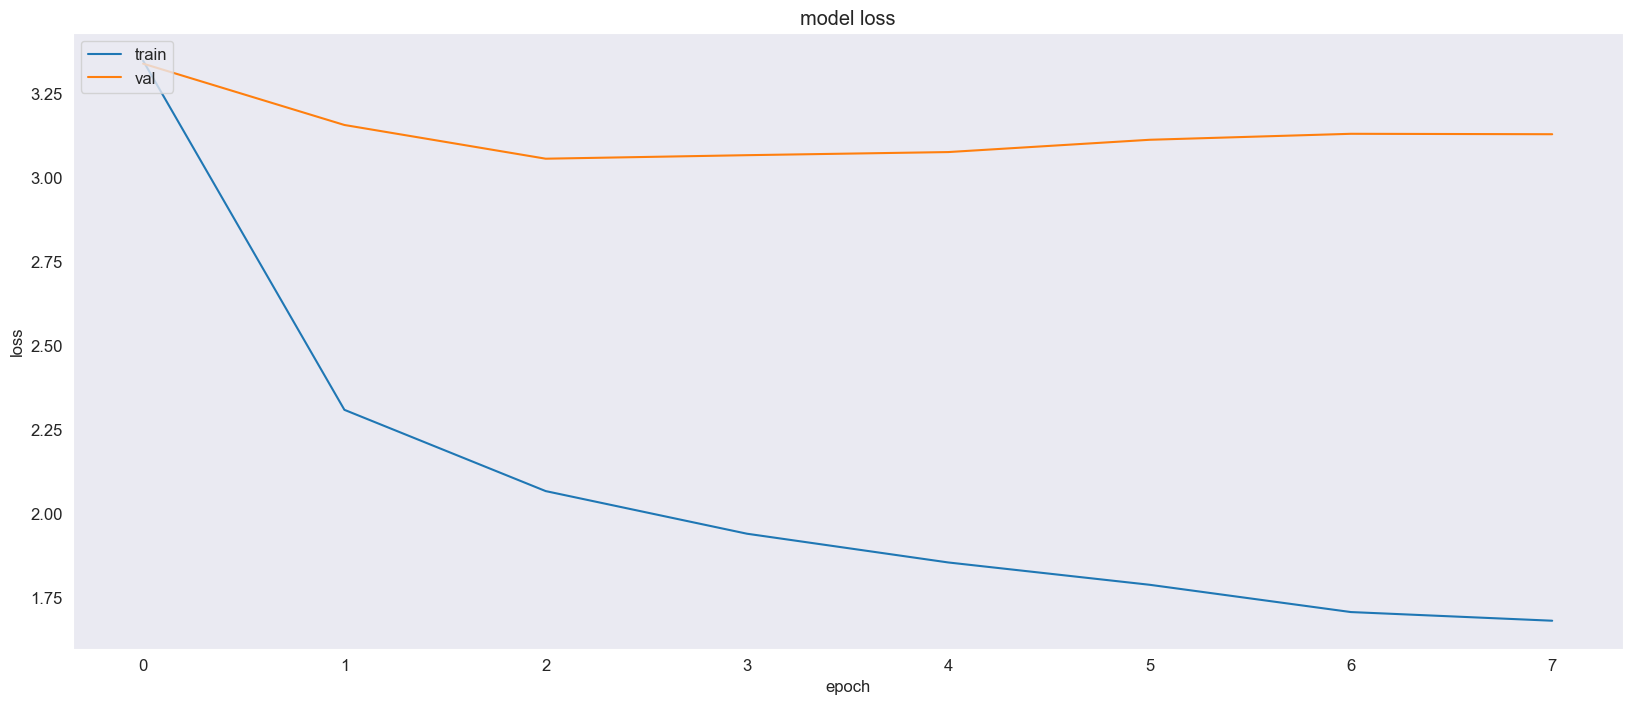

In [92]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption